In [1]:
from __future__ import print_function
import six

# import modules
import sys
import os
import time
import inspect
import getopt
import yaml
from pprint import pprint # for human readable file output
try:
    import cPickle as pickle
except:
    import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
import matplotlib.font_manager as font_manager
import scipy.stats as sps

In [2]:
## modify this for the location of mm3 on your computer
helpers_folder = os.path.realpath('/Users/ryan/napari-mm3/src/napari_mm3/')

if helpers_folder not in sys.path:
    sys.path.insert(0, helpers_folder)
    
import utils_plotting as mm3

### Load cell file and specs file

- The cell file contains all cell objects and their attributes (fov & peak ID, size over time, elongation rate, generation time, etc.).
- The specs file contains a list of all fovs and "peaks" (i.e. growth channels) analyzed in the experiment.

In [3]:
## replace these with paths to your own files
# cellfile_path = '/Volumes/JunLabSSD_03/20171225_fs104_gly11aa/analysis/cell_data/20171225_complete_cells_otsu.json'
cellfile_path = '/Users/ryan/Google Drive/Jun_Lab/mm3_paper/data/20171225_fs104/otsu/20171225_complete_cells_otsu.json'
# specfile_path = '/Volumes/JunLabSSD_03/20171225_fs104_gly11aa/analysis/specs.yaml'
specfile_path = '/Users/ryan/Google Drive/Jun_Lab/mm3_paper/data/20171225_fs104/otsu/specs.yaml'

# with open(
#     cellfile_path,
#     'rb')as cell_file:
#     Cells = pickle.load(cell_file, encoding='latin1')
Cells = mm3.read_cells_from_json(cellfile_path)

# load specs file
with open(specfile_path, 'r') as specs_file:
    specs = yaml.safe_load(specs_file)

### Make a dictionary of cell lineages with fov & peak # as keys

This is convenient for plotting individual cell lineages.

In [4]:
## get cells by peak
Cells_by_peak = mm3.organize_cells_by_channel(Cells, specs)

## Print the peak IDs for FOV 1
Cells_by_peak[2].keys()

dict_keys([119, 193, 340, 705, 779, 1070, 1142, 1289, 1362, 1434, 1652, 1869, 2014, 2232, 2304, 2376, 2449])

### Plot lineage trace for given FOV & peak ID

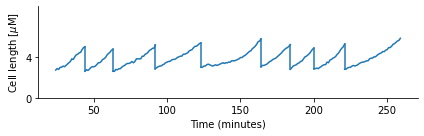

In [10]:
fov_id = 2
peak_id = 1070

fig= plt.figure(figsize=(6,2))
ax=plt.axes()

for cell_id, cell in Cells_by_peak[fov_id][peak_id].items():
    if cell.birth_label==1:
        ax.plot(cell.times_w_div,np.array(cell.lengths_w_div),color='C0')
        try:
            cell_m = Cells[cell.parent]
            ax.plot([cell_m.division_time,cell.birth_time],[cell_m.sd,cell.sb],ls='-',color='C0')
        except:
            pass

ax.set_ylim(bottom=0,top=9)
ax.set_yticks([0,4])
sns.despine()

ax.set_ylabel('Cell length [$\mu$M]')
ax.set_xlabel('Time (minutes)')
plt.tight_layout()

### Filter for cells whose parameters are within n std. dev. of their means
- If we are concerned with the mean or general shape of parameter distribution, this is useful to remove segmentation or tracking errors.
- Be careful if you are concerned with extracting info about rare events or from the tails of distributions.

In [5]:
fCells = mm3.filter_by_stat(Cells,center_stat='mean', std_distance=4)

### Convert the cell file into a pandas dataframe
- dataframe is useful for filtering and plotting scalar (not time series) attributes

In [6]:
df = mm3.cells2df(fCells)

### Adder correlations

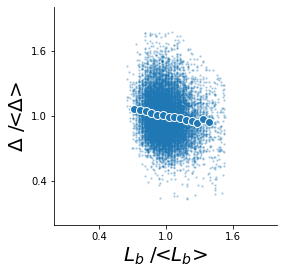

In [7]:
%matplotlib inline
col = df['sb']/np.mean(df['sb'])
row = df['delta']/np.mean(df['delta'])

fig=plt.figure(figsize=(4,4))
ax=plt.axes()

x = np.linspace(0.4,1.6)
y = np.ones(len(x))

# optionally plot full scatter plot
ax.scatter(col, row,
                  s=2, alpha=0.25, color='C0', lw=1,
                  marker='o', label=None,
                  rasterized=True, zorder=1)

# calculate bin means
bin_c, bin_m, bin_e = mm3.binned_stat(col, row, bin_edges='sturges',binmin= 50)

ax.errorbar(bin_c, bin_m, yerr=bin_e, xerr=None,
              marker='o', ms=8, alpha=1,ls='-',
              lw=1, mew=1, mec='white',mfc='C0', color='C0',
              elinewidth=0.5, capsize=1, capthick=0.5,
              zorder=2, label='Otsu')


ax.set_xticks([.4,1,1.6])
ax.set_yticks([.4,1,1.6])
ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.set_xlabel('$L_b$ /<$L_b$>',fontsize=20)
ax.set_ylabel('$\Delta$ /<$\Delta$>',fontsize=20)
sns.despine()


### Plot distributions and correlations of cell cycle parameters

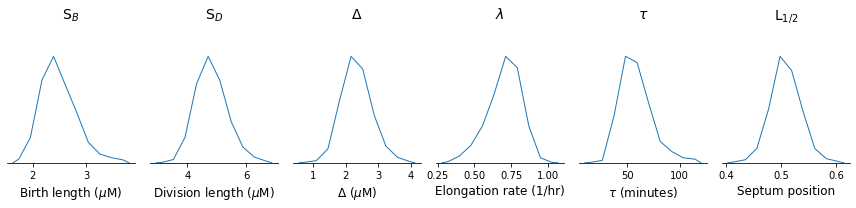

In [8]:
cols = ['sb', 'sd', 'delta', 'elong_rate', 'tau', 'septum_position']
mm3.plot_distributions(df, cols)

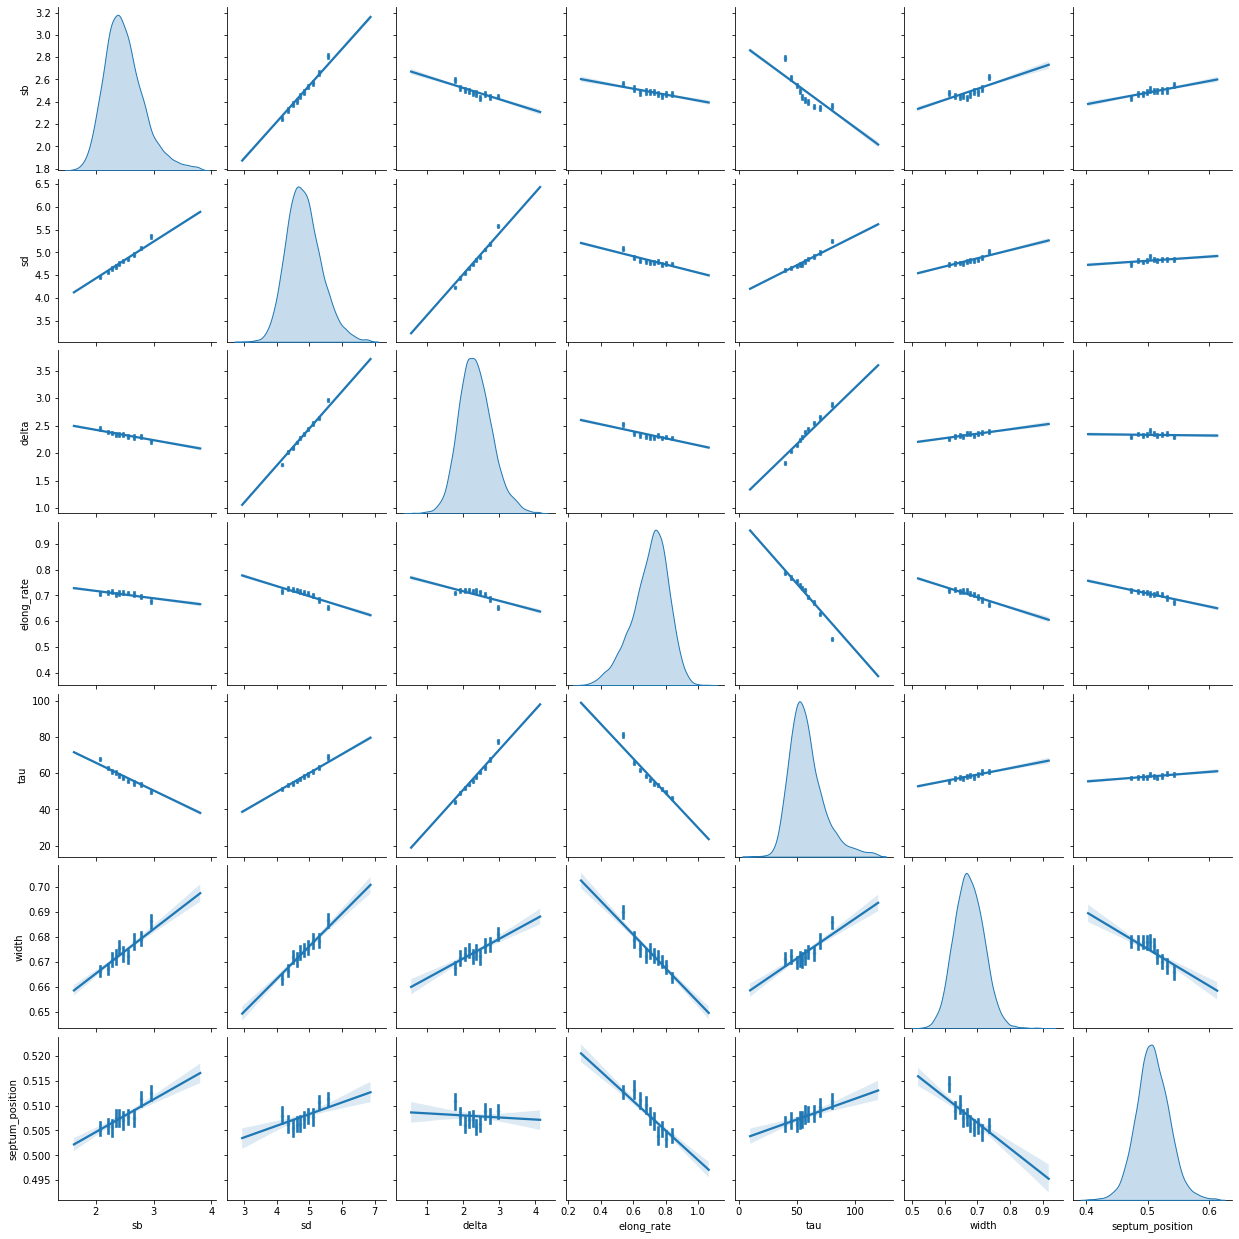

In [21]:
include_columns = ['sb', 'sd', 'delta', 'elong_rate', 'tau', 'width','septum_position']

g = sns.pairplot(df[include_columns], kind='reg',diag_kind = 'kde',
                 plot_kws={'scatter':True,'x_bins':10,'scatter_kws':{'alpha':0.25,'s':10}})

### Plot parameters over time

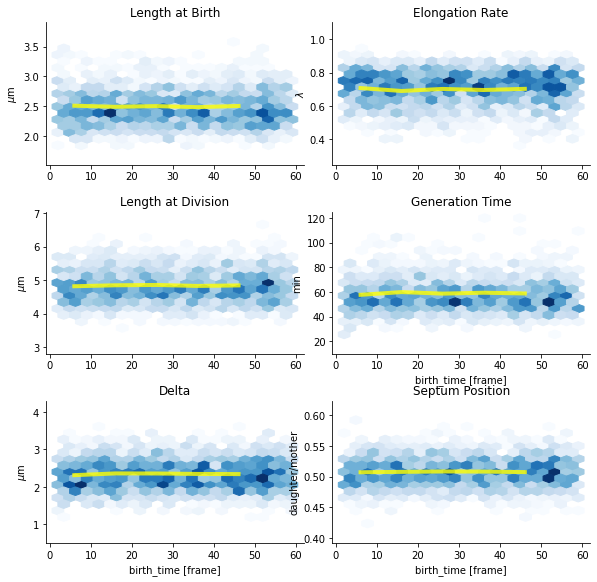

In [19]:
fig, ax = mm3.plot_hex_time(df.query('birth_time<60'))
sns.despine()